In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import os, re
import time
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
from scipy.fftpack import fft, ifft

import stfft
import general
import eegFilter
from eegAnalysis import EEGAnalysis

from tqdm import tqdm

```python
            "delta":(  2,  4),
            "theta":(  4,  8),
            "alpha":(  8, 12),
            "beta": ( 15, 30),
            "gamma":( 30,150),
            "low gamma": (30, 80),
            "high gamma":(80,150),
            "lowpass":(1,200),
            "highpass":(200,500)
```

In [24]:
datadir = "../../Data"
resultdir = "../../Result/"
patientName = "Chen Zhou"
# patientName = "Demo"
fs = 2000

targetfiles = "180903-2-5"
# targetfiles = "999999-9-9"
chidx = 108
cutoffband = "lowpass"
lowcut, highcut = eegFilter.getbandrange(cutoffband)

##### set target files #####
# files = []
# matching_pattern = r"\d{6}-.*?\.mat"
# for item in os.listdir(os.path.join(datadir, patientName, "EEG", "Compact")):
#     if re.match(matching_pattern, item):
#         possibleResultFile = os.path.splitext(item)[0] + ".csv"
#         if not os.path.exists(os.path.join(resultdir, patientName, possibleResultFile)):
#             files.append(os.path.splitext(item)[0])

print("file:", targetfiles, '\nchannel:',chidx+1, '\nbandpass:', cutoffband)
analysis = EEGAnalysis(
        datadir = datadir,
        resultdir = resultdir,
        patientname = patientName,
        expname = targetfiles,
        fs=fs,
        roi=(-2,5))

file: 180903-2-5 
channel: 109 
bandpass: lowpass


CPU times: user 3.34 s, sys: 611 ms, total: 3.95 s
Wall time: 4.03 s


<Figure size 432x288 with 0 Axes>

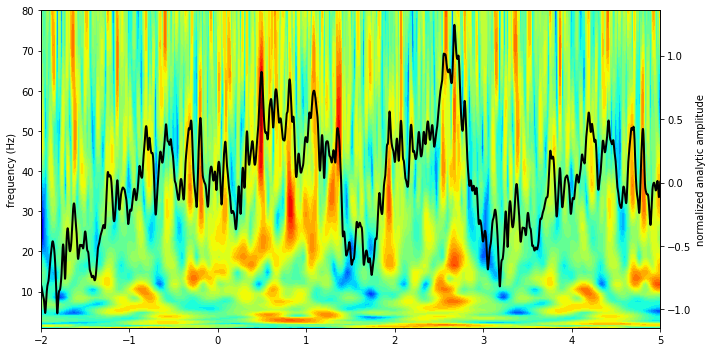

In [8]:
frange = np.logspace(np.log10(lowcut), np.log10(80), 40) # 80, 200, 500
tspec = np.linspace(analysis.roi[0], analysis.roi[-1], (analysis.roi[1] - analysis.roi[0])*analysis.fs)
# baseroi = (1,2)
cue_onset = analysis.markers["grating"][0][0][0,:]
ch_split = general.split_datawithmarker(analysis.channels[chidx, :], 
#                                         [cue_onset[0]], 
                                        cue_onset-1,
                                        analysis.roi, analysis.fs)
%time pxx = stfft.dwt_tf(ch_split, analysis.fs, frange, reflection=True, zscore=True)


plt.figure()
fig, ax1 = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)

cont = ax1.contourf(np.linspace(-2,5,3500), frange, pxx[:,::4], 40, cmap=plt.get_cmap("jet"))
ax1.set_xlim([tspec[0], tspec[-1]])
ax1.set_ylabel("frequency (Hz)")
# cont.set_clim(-1, 2)

ax2 = ax1.twinx()
ax2.plot(tspec, np.mean(pxx,0),'k', linewidth=2)
ax2.set_ylabel("normalized analytic amplitude")

fig.tight_layout()
plt.show()

plt.close('all')

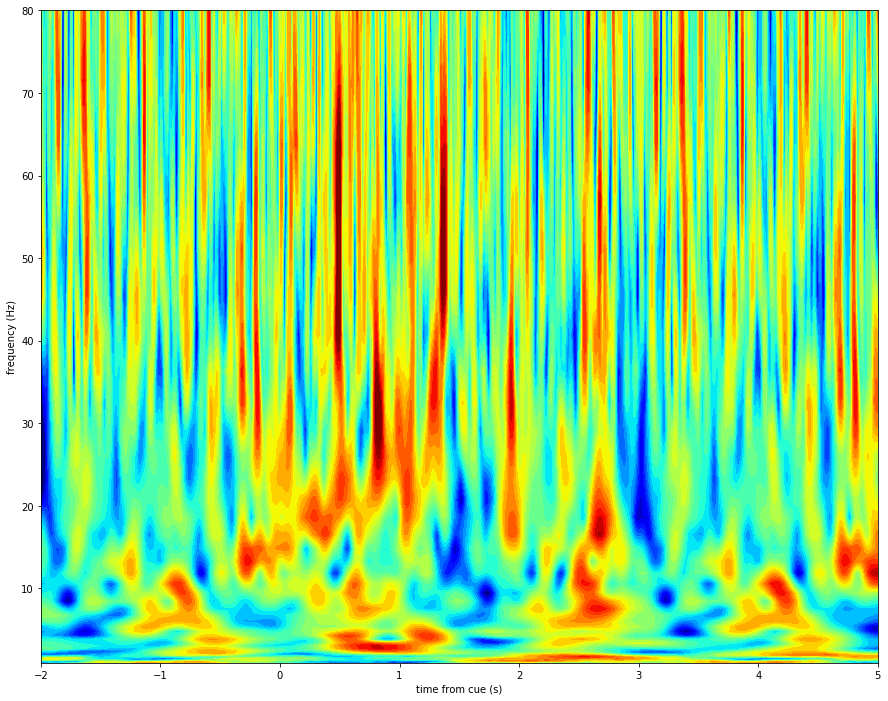

In [9]:
# tf domain
plt.figure(figsize=(15,12))
plt.contourf(np.linspace(-2,5,3500), frange, pxx[:,::4], 40, cmap=plt.get_cmap("jet"))
plt.xlabel("time from cue (s)")
plt.ylabel("frequency (Hz)")
plt.clim([-3,3])
# plt.show()
plt.savefig("somatosensory_demo_notap_grating_tf_0_80.eps")
# plt.savefig("occipital_demo_noentrain_grating_tf_0_80.eps")

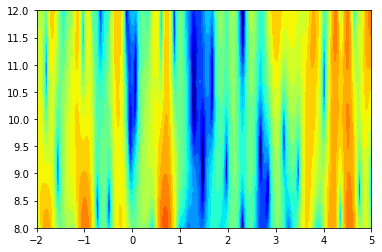

In [78]:
# tf domain
plt.contourf(np.linspace(-2,5,3500), frange, pxx[:,::4], 40, cmap=plt.get_cmap("jet"))
plt.clim([-3,3])
plt.show()

In [27]:
print(analysis.markers["grating"][0][0][0,:])

[ 3.  8. 13. 18. 23. 28. 33. 38. 43. 48. 53. 58. 63. 68. 73. 78. 83. 88.
 93. 98.]


# analysis.channels[1,:]

CPU times: user 92 ms, sys: 165 ms, total: 257 ms
Wall time: 346 ms


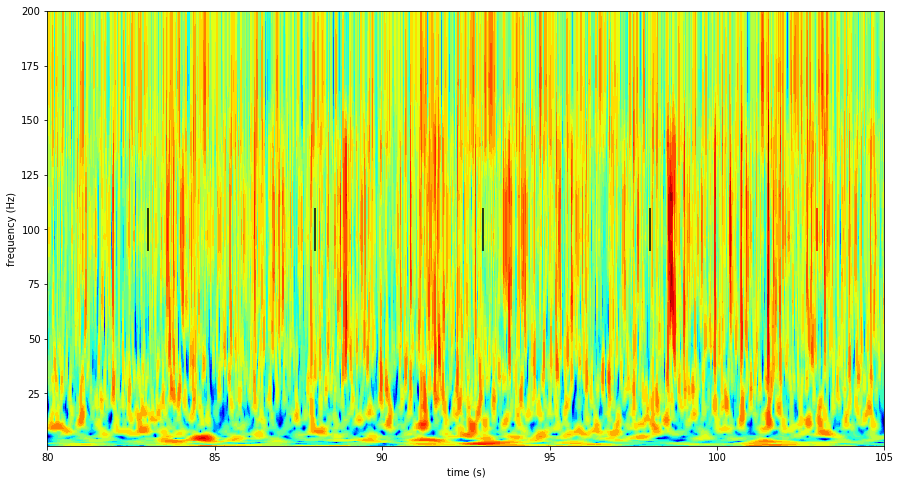

In [28]:
rho = 10
chidx = 98
trange = (80.0, 105.0)
fs = analysis.fs

cutoffband = "lowpass"
lowcut, highcut = eegFilter.getbandrange(cutoffband)
frange = np.logspace(np.log10(lowcut), np.log10(highcut), 30) # 80, 200, 500

curve_roi = analysis.channels[chidx,:][int(trange[0]*fs):int(trange[0]*fs)+int(fs*(trange[1]-trange[0]))]
curve_roi = np.reshape(curve_roi, (1, len(curve_roi)))

%time pxx = stfft.dwt_tf(curve_roi[:, ::rho], int(fs//rho), frange, reflection=True, zscore=True)

plt.figure(figsize=(15,8))
plt.contourf(np.linspace(trange[0],trange[1], np.size(pxx, 1)), frange, pxx, 40, cmap=plt.get_cmap("jet"))
plt.vlines(analysis.markers["grating"][0][0][0,:], 90, 110)
plt.vlines(analysis.markers["entrain"][0][0][0,:], 90, 110, 'r')

plt.xlabel("time (s)")
plt.ylabel("frequency (Hz)")
plt.clim([-3,3])
plt.xlim(trange)

plt.show()

---
# ITPC

In [5]:
def dwt_tf(eeg_data, fs, frange, baseroi=None, reflection=False, zscore=False, averageall=True, rawresult=False):
    """time frequency decomposition analysis with wavelet tranform
    
    Syntax: Pxx = dwt_tf(eeg_data, fs, frange, baseroi)
    
    Keyword arguments:
    data       -- a m*n numpy.ndarray. 
                  columns as observations, 
                  rows as raw data.
    fs         -- sampling frequency
    frange     -- frequency array for calculation
    baseroi    -- range for normalization baseline
    reflection -- perform data reflection, compensate the edge effect
    zscore     -- using zscore normalization
    averageall -- return averaged total power
    """
    if reflection:
        eeg_data_flip = np.fliplr(eeg_data)
        fft_eeg_data = np.hstack((eeg_data_flip, eeg_data))
        fft_eeg_data = np.hstack((fft_eeg_data, eeg_data_flip))
        pass
    else:
        fft_eeg_data = eeg_data
        
    # wavelet parameters
    wtime = np.linspace(-1,1,int(2*fs))
    nConv = np.size(fft_eeg_data, 1) + int(2*fs)
    fft_eeg = np.fft.fft(fft_eeg_data, nConv)
    
    if averageall:
        Pxx = np.zeros((np.size(frange), np.size(fft_eeg_data, 1)))
    elif rawresult:
        Pxx = np.zeros((np.size(frange), np.size(eeg_data, 0), np.size(fft_eeg_data, 1)), dtype='complex')
    else:
        Pxx = np.zeros((np.size(frange), np.size(eeg_data, 0), np.size(fft_eeg_data, 1)))
    
    for idx, F in enumerate(frange):
        s = 6 / (2 * np.pi * F)
        wavelet = np.exp(2*1j*np.pi*wtime*F) * np.exp(- wtime**2/(2*s**2))  # morlet wavelet
        fft_wavelet = np.fft.fft(wavelet, nConv)
        
        conv_wave = np.fft.ifft(fft_wavelet*fft_eeg, nConv)
        conv_wave = conv_wave[:, fs:-fs]
        
        if averageall:
            temppow = np.mean(np.abs(conv_wave)**2,0)
        elif rawresult:
            Pxx[idx, :, :] = conv_wave
            continue
        else:
            Pxx[idx, :, :] = np.abs(conv_wave)**2
            continue
        
        if zscore:
            temppow_cal = 10*np.log10(temppow)  # db-calibration
            temppow_cal = (temppow_cal-np.mean(temppow_cal))/np.std(temppow_cal)
        
        else:
            temppow_cal = 10*np.log10(temppow/np.mean(temppow))  # db-calibration
#         temppow_cal = 10*np.log10(temppow)
        Pxx[idx, :] = temppow_cal

    if reflection:
        if averageall:
            return Pxx[:, np.size(eeg_data,1):-np.size(eeg_data,1)]
        else:
            return Pxx[:,:,np.size(eeg_data,1):-np.size(eeg_data,1)]
    else:
        return Pxx

CPU times: user 3.05 s, sys: 583 ms, total: 3.64 s
Wall time: 3.78 s


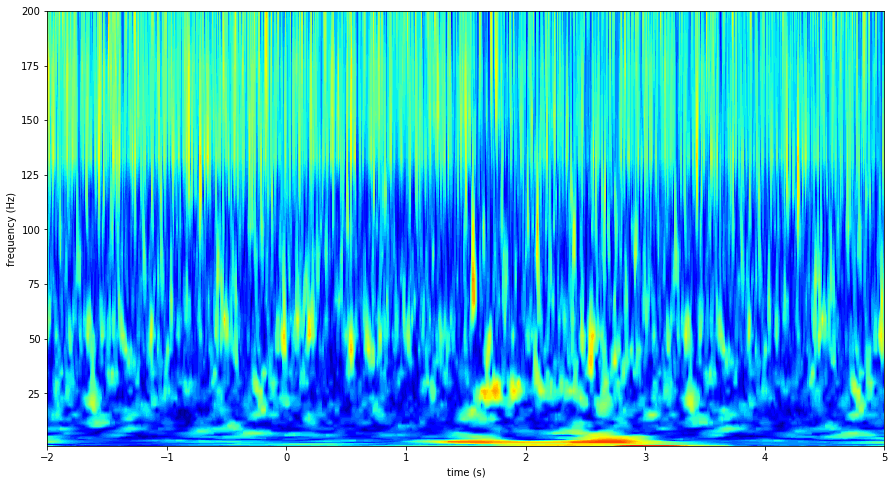

In [25]:
frange = np.logspace(np.log10(lowcut), np.log10(200), 40) # 80, 200, 500
tspec = np.linspace(analysis.roi[0], analysis.roi[-1], (analysis.roi[1] - analysis.roi[0])*analysis.fs)
# baseroi = (1,2)
cue_onset = analysis.markers["grating"][0][0][0,:]
ch_split = general.split_datawithmarker(analysis.channels[chidx, :], 
#                                         [cue_onset[0]], 
                                        cue_onset-1,
                                        analysis.roi, analysis.fs)
%time pxx = dwt_tf(ch_split, analysis.fs, frange, reflection=True, zscore=False, averageall=False, rawresult=True)

itpc = np.abs(np.sum(pxx/np.abs(pxx), 1) / np.size(pxx, 1))

plt.figure(figsize=(15,8))
plt.contourf(np.linspace(-2,5, np.size(itpc, 1)), frange, itpc, 40, cmap=plt.get_cmap("jet"))

plt.xlabel("time (s)")
plt.ylabel("frequency (Hz)")
plt.clim([0,1])
plt.xlim([-2, 5])

# plt.show()
# plt.savefig("preview/"+targetfiles+".png", bbox_inches="tight")
plt.show()
plt.close("all")